# Training Continuous BFN on MNIST

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax.numpy as jnp
import jax
import jax.random as jr
import jax.tree_util as tu
import optax
import einops



import numpy as np
import mediapy as media
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
import time

In [3]:
import dfm.loss_and_sample as las
import dfm.mnist_data as example_data
import dfm.training as training
import dfm.mnist_model as mnist_model

## Main

### Defining Dataset and Model

In [4]:
batch_size = 256
mnist_dataset = example_data.MNISTDataset(train=True, num_cats=2, digits={4, 7, 8})

dataloader = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True, collate_fn=jnp.stack)
print(f"There are {len(mnist_dataset)} samples in the dataset")

There are 17958 samples in the dataset


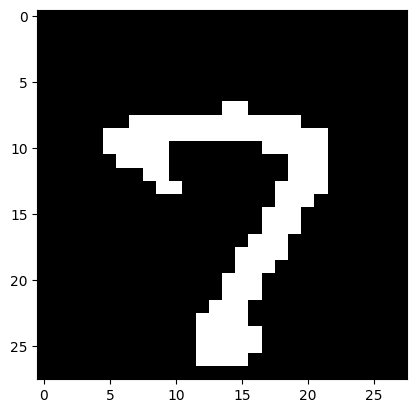

In [5]:
example_image = mnist_dataset[12]
h, w = example_image.shape

plt.imshow(example_image, cmap="gray")

In [6]:
model_kwargs = {"num_blocks": 4, "patch_size": 4, "hidden_size": 64, "mix_patch_size": 512, "mix_hidden_size": 512}

model = mnist_model.Mixer2D(num_cats=mnist_dataset.num_cats, **model_kwargs)

example_x = jax.nn.one_hot(example_image, mnist_dataset.num_cats, axis=-1)
variables = model.init(jr.PRNGKey(0), example_x, jnp.array(0.5))
params = variables["params"]

num_params = sum(x.size for x in tu.tree_leaves(params))
print(f"Number of parameters: {num_params}")

Number of parameters: 478743


### Training

In [7]:
LEARNING_RATE = 2e-3
optim = optax.adam(LEARNING_RATE)
opt_state = optim.init(params)

In [8]:
NUM_EPOCHS = 100
losses = []
key = jr.PRNGKey(0)
t_infty = 8.0
for _ in (pbar := tqdm(range(NUM_EPOCHS))):
    epoch_loss = 0.0
    for i, x_batch in enumerate(dataloader):
        key, subkey = jr.split(key)
        loss, params, opt_state = training.make_step(model, x_batch, optim, opt_state, params, t_infty, key=subkey)
        epoch_loss += loss
    avg_loss = epoch_loss / (i + 1)  # Approximate since batches not common divisor of dataset size
    losses.append(avg_loss)
    pbar.set_description(f"Loss: {avg_loss:.2f}")

losses = jnp.array(losses)

  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.03: 100%|██████████| 100/100 [03:23<00:00,  2.04s/it]


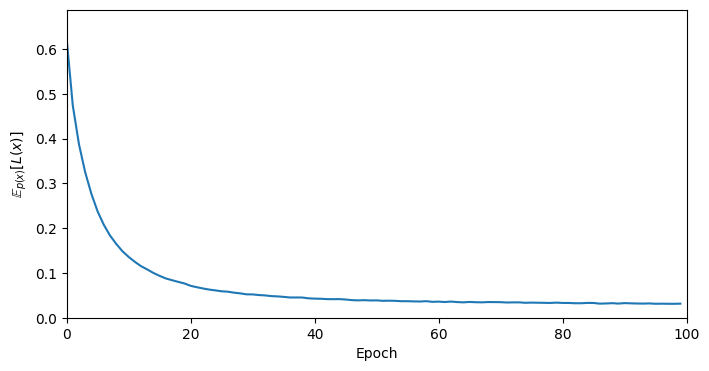

In [9]:
# Plot losses
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(losses)

_ = ax.set_xlabel("Epoch")
_ = ax.set_ylabel(r"$\mathbb{E}_{p(x)}[L(x)]$")  # Not actually the expectation because summing loss in each epoch
_ = ax.set_xlim(0, losses.shape[0])
_ = ax.set_ylim(0, 1.1 * jnp.max(losses))

### Sampling from Trained Model

In [10]:
steps = 100

def single_sample(key):
    return las.sample(params, model, t_infty, steps, shape=example_image.shape, key=key)

sample_key = jr.PRNGKey(80)
steps = 100
x_hat, xs_output = jax.vmap(single_sample)(jr.split(sample_key, 32))

x_hat = einops.rearrange(x_hat, "(b1 b2) h w -> (b2 h) (b1 w)", b1=8)
xs_output = einops.rearrange(xs_output, "(b1 b2) t h w c -> t (b2 h) (b1 w) c", b1=8)
xs_output = xs_output.argmax(axis=-1)

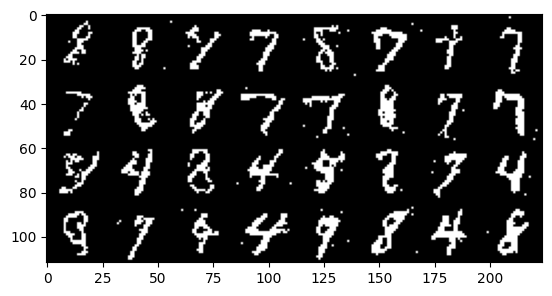

In [11]:
# Samples currently no good, probably because network isn't expressive enough
plt.imshow(x_hat, cmap="gray")

""

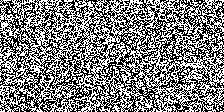

In [12]:
frames_uint8 = np.array(xs_output * 255 / (mnist_dataset.num_cats - 1), dtype=np.uint8)

# NOTE: regenerating this video requires `ffmpeg`
media.show_video(frames_uint8, height=320, fps=24, codec='gif', border=True)